# Improving Our Tax-Assessed Value Predictions

In [1]:
# reloads import files each time a cell is ran
%load_ext autoreload
%autoreload 2

# ignore warnings/import display library
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

# modeling imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# stats and math imports
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from scipy import stats

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# tools and custom files
import itertools
import env
import wrangle as wr
import acquire
import prepare
import split
import exploration as exp
import modeling as md

# global variable, will never change
alpha = 0.05

# Project Overview

## What:
> * Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction in 2017.
> * Discover drivers or non-drivers of property tax value for single family properties
> * Deliver a report and recommendations based on the findings from above
> * Discover the location of the properties so Zach doesn't have to keep searching for that
email.

## Why:
> * We want to make improvements on our current model for predicting property tax value
> * To help customers feel more confident in our product and helps us make better business decisions

## How:

> * We're going to go through the data science pipeline by acquiring our data, preparing it, exploring it, and then modeling it.

# Executive Summary - Findings & Next Steps

### Key Drivers - Square Feet, Bathroom Count, Proximity To Certain Locations

#### Locations: Los Angeles County, Orange County, and Ventura County

### Model Performance: 
> * Test RMSE of **278,000 dollars**, improving on the last model by roughly **33%**.

### Recommendations/Further Analysis:

> * Research other house properties to see what else could improve our model.
> * Try to research whether other distance-based features could be used, such as proximity to schools, to vacationing areas, etc.
> * Make linear regressions for each county, which will likely improve overall performance.

# Acquire Target Data

### Acquire Goal:
> Acquire and save data for Single Family Homes that had a transaction in 2017

In [2]:
# Queues the sql database for zillow data and writes to csv.
# Acquires/Cleans Data
zillow, categories, quant_cols = wr.wrangle_zillow()
df = zillow.copy()

# define target variable
target_var = 'taxvaluedollarcnt'

# show info/standard statistics for the dataframe
print(zillow.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51119 entries, 0 to 52441
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   parcelid           51119 non-null  int64  
 1   bedroomcnt         51119 non-null  float64
 2   bathroomcnt        51119 non-null  float64
 3   sqr_ft             51119 non-null  float64
 4   taxvaluedollarcnt  51119 non-null  float64
 5   yearbuilt          51119 non-null  float64
 6   county             51119 non-null  object 
 7   latitude           51119 non-null  float64
 8   longitude          51119 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 3.9+ MB
None


### Initial Thoughts:

> * county needs to be encoded
> * Most floats need to be scaled due to different units of measure (except target var & lat/lon)

# Prepare

### Prepare Goals: 
> * Clean data of any missing/null values and identify/correct any data that isn't helpful.
> * Split data into train, validate, and test sets for exploration and modeling.

In [3]:
# cleans/prepares zillow data, splits into train, validate, test sets
all_counties = md.LRM(df, target_var, county='all')
all_counties.train.head()

,index,parcelid,bedroomcnt,bathroomcnt,sqr_ft,taxvaluedollarcnt,yearbuilt,county,latitude,longitude,...,dist_balboa_island,dist_laguna_beach,dist_seal_beach,dist_simi,dist_ventura,dist_channel_islands,dist_ojai,dist_eleanor,scaled_OC,scaled_ventura
0,37081,14282205,3.0,2.0,1604.0,667392.0,1956.0,orange_county,33.638392,-117.901047,...,-0.924861,-0.848921,-0.537515,0.798256,0.739388,0.787394,0.866301,0.702908,1.0,0.0
1,22281,17075855,4.0,3.0,2850.0,475634.0,1978.0,ventura,34.284344,-119.284310,...,1.719159,1.669648,2.222510,-0.487593,-2.330260,-1.606794,-1.906196,-0.642817,0.0,1.0
2,11886,13848424,3.0,1.0,1049.0,306402.0,1949.0,orange_county,33.719151,-117.880553,...,-0.760312,-0.739030,-0.568501,0.711347,0.687555,0.700411,0.793307,0.641547,1.0,0.0
3,37130,11008244,4.0,3.0,2505.0,278696.0,1986.0,los_angeles,34.327484,-118.428014,...,0.719806,0.707754,0.795377,-0.764877,-0.672956,-0.722446,-0.719200,-0.595460,0.0,0.0
4,21594,13068561,3.0,3.0,2616.0,500852.0,1984.0,los_angeles,34.025463,-117.856454,...,-0.140311,-0.179081,-0.081590,0.422241,0.496224,0.311379,0.516489,0.460756,0.0,0.0


### Acquire/Prepare keypoints:

> * Wrote SQL to queue the Codeup database, write the results to csv. If csv already exists, read from csv instead.
> * Rows with null values made up 0.6% of all data ---> Felt comfortable dropping.
> * Dropped data that was statistically insignificant/extreme outliers (> 3.5 standard deviations)
> * Identified homes with 0 bathrooms and 0 bedrooms as inappropriate for single families ---> Dropped those rows.
> * Used California minimum requirements for bedroom square footage to estimate incorrect square footage data ---> incorrect square footage was dropped
> * Latitude and Longitude values had to be adjusted 
> * Data split into train, validate, test sets and encoded for model compatability.



# Most Importantly:


### 98% of the data is clean and without obvious errors.

# Exploration

### Exploration goal: Understand and explore data to identify key drivers of property tax assesd value.

#### Initial Questions:
*'Basic Features' will refer to bedroomcnt, bathroomcnt, square feet, year built*

> * Which basic features are most correlated to home value?
> * Are the correlations different when separated by county?
> * Is geographic location correlated to home value?
> * Which features can we add related to geographic location?

In [4]:
# set array of basic features for future usage
basic_features= np.array([['bedroomcnt', 'bathroomcnt'], ['sqr_ft', 'yearbuilt']])

## Which basic features are most correlated to home value?

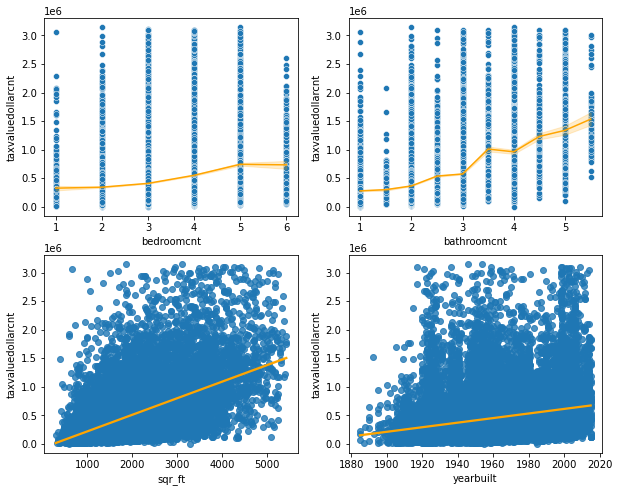

In [5]:
# create basic scatter plots to show distribution and mean values
exp.basic_feature_plots(all_counties.train)

### Takeaways:
> * Bathroomcnt and Square Feet seem to have a higher relation to mean home value
> * Bedroomcnt seems to have a smaller relationship to home value than initially expected.

## Statistical Testing:

### Does square feet have a significant relation to home value?

> **Null Hypothesis:** Square feet **does not** have a significant relation to home value.  

> **Alternative Hypothesis:** Square feet **does** have a significant relation to home value.

In [6]:
# use pearsonr test
r, p = stats.pearsonr(all_counties.train.sqr_ft, all_counties.train.taxvaluedollarcnt)
print(f'r value: {r},  p value: {p}\n')

# Reject or accept null hypothesis based off of alpha
if p > alpha:
    print("We fail to reject the null hypothesis that square feet does not have a significant relation to home value.")
else:
    print("We reject the null hypothesis and say square feet does have a significant relation to home value.")

r value: 0.565484522095982,  p value: 0.0

We reject the null hypothesis and say square feet does have a significant relation to home value.


### Does bathroomcnt have a significant relation to home value?

> **Null Hypothesis:** Bathroomcnt **does not** have a significant relation to home value.  

> **Alternative Hypothesis:** Bathroomcnt **does** have a significant relation to home value.

In [7]:
# use pearsonr test
r, p = stats.pearsonr(all_counties.train.sqr_ft, all_counties.train.taxvaluedollarcnt)
print(f'r value: {r},  p value: {p}\n')


# Reject or accept null hypothesis based off of alpha
if p > alpha:
    print("We fail to reject the null hypothesis that bathroomcnt does not have a significant relation to home value.")
else:
    print("We reject the null hypothesis and say bathroomcnt does have a significant relation to home value.")

r value: 0.565484522095982,  p value: 0.0

We reject the null hypothesis and say bathroomcnt does have a significant relation to home value.


### Correlation heatmap

<AxesSubplot:>

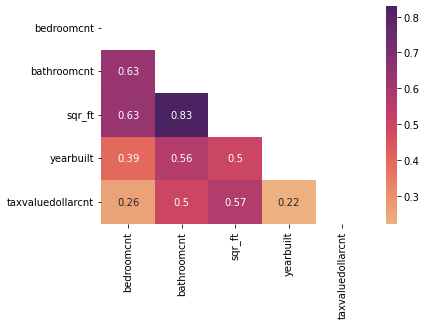

In [8]:
# creating filter for basic_features
basic_tax = list(basic_features.flatten())
basic_tax.append('taxvaluedollarcnt')

# creating subset df for basic features & target variable
basic_feat_df = all_counties.train[basic_tax]
corr = basic_feat_df.corr()

# heatmap visualization
sns.heatmap(corr, annot=True, cmap='flare',mask=np.triu(corr))

## Are these correlations stronger or weaker in different counties?

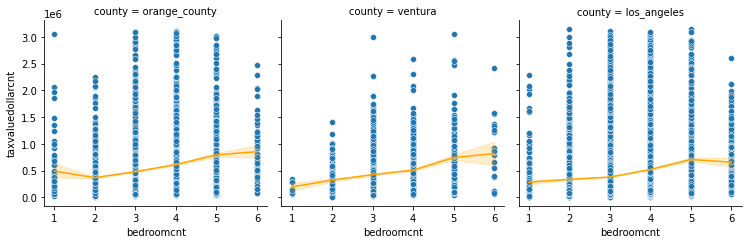

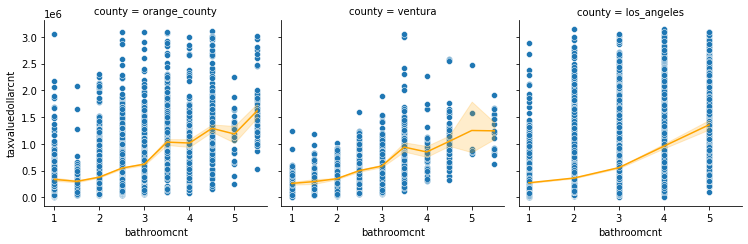

In [9]:
# plot basic features with either mean home value line, split by county
exp.rel_plots(all_counties.train, target_var, basic_features[0], 'county')

### Takeaway:

> * Ventura county has a tighter distribution of home value in regards to bedroom and bathroom counts.

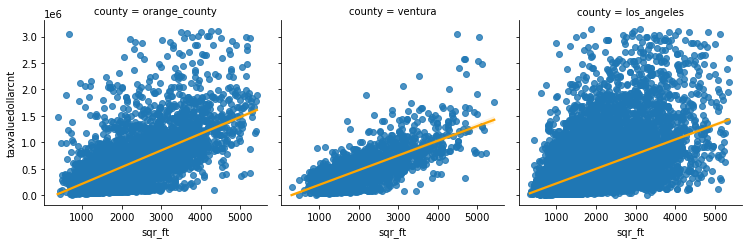

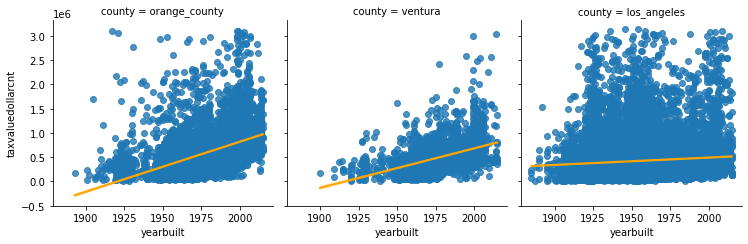

In [10]:
# loop through [sqr_ft, yearbuilt] to graph scatterplots with regression lines
for f in basic_features[1]:
    sns.lmplot(data=all_counties.train,x=f,y=target_var, fit_reg=True, col='county', height=3.5, aspect=1,
               line_kws={'color': 'orange'})
    

### Takeaways:

> * Again, ventura has a tighter distribution of home value, basic features could be more predictive for ventura
than other counties.

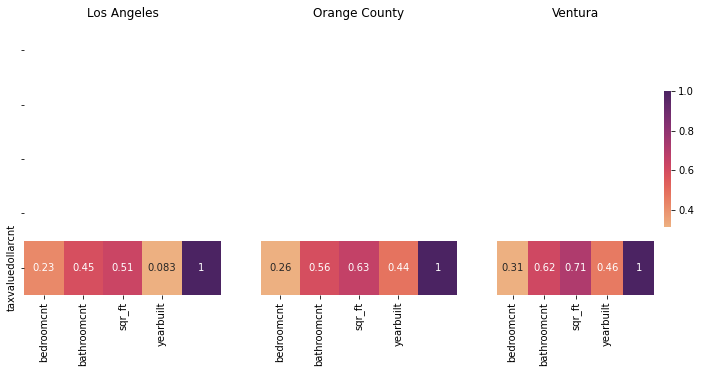

In [11]:
# creating subset df for basic features & target variable

# creating df subsets by county
la_df = all_counties.train[all_counties.train.county == 'los_angeles'][basic_tax]
oc_df = all_counties.train[all_counties.train.county == 'orange_county'][basic_tax]
ventura_df = all_counties.train[all_counties.train.county == 'ventura'][basic_tax]

# creating corr matrices for each county
la_corr = la_df.corr()
oc_corr = oc_df.corr()
ventura_corr = ventura_df.corr()

# create mask to cut unncessary rows
mask = np.zeros_like(la_corr)
mask[:4, :] = True

# heatmap visualization
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
cmap = 'flare'

# first heatmap, only showing row of taxvaluedollarcnt
p1 = sns.heatmap(la_corr, annot=True, cmap=cmap, mask=mask, ax=ax[0], cbar=False, xticklabels=basic_tax[0:4], yticklabels=[' ', '', '', '', 'taxvaluedollarcnt'])
p1.title.set_text('Los Angeles')

# second heatmap
p2 = sns.heatmap(oc_corr, annot=True, cmap=cmap, mask=mask, ax=ax[1], cbar=False, yticklabels=False, xticklabels=basic_tax[0:4])
p2.title.set_text('Orange County')

# third heatmap
p3 = sns.heatmap(ventura_corr, annot=True, cmap=cmap, mask=mask, ax=ax[2], yticklabels=False, xticklabels=basic_tax[0:4], cbar_kws={'shrink':.5})
p3.title.set_text('Ventura')

print()

### Takeaway:

> * Basic features are probably better predictors for Ventura compared to other counties, especially Los Angeles

# Is location related to home value?

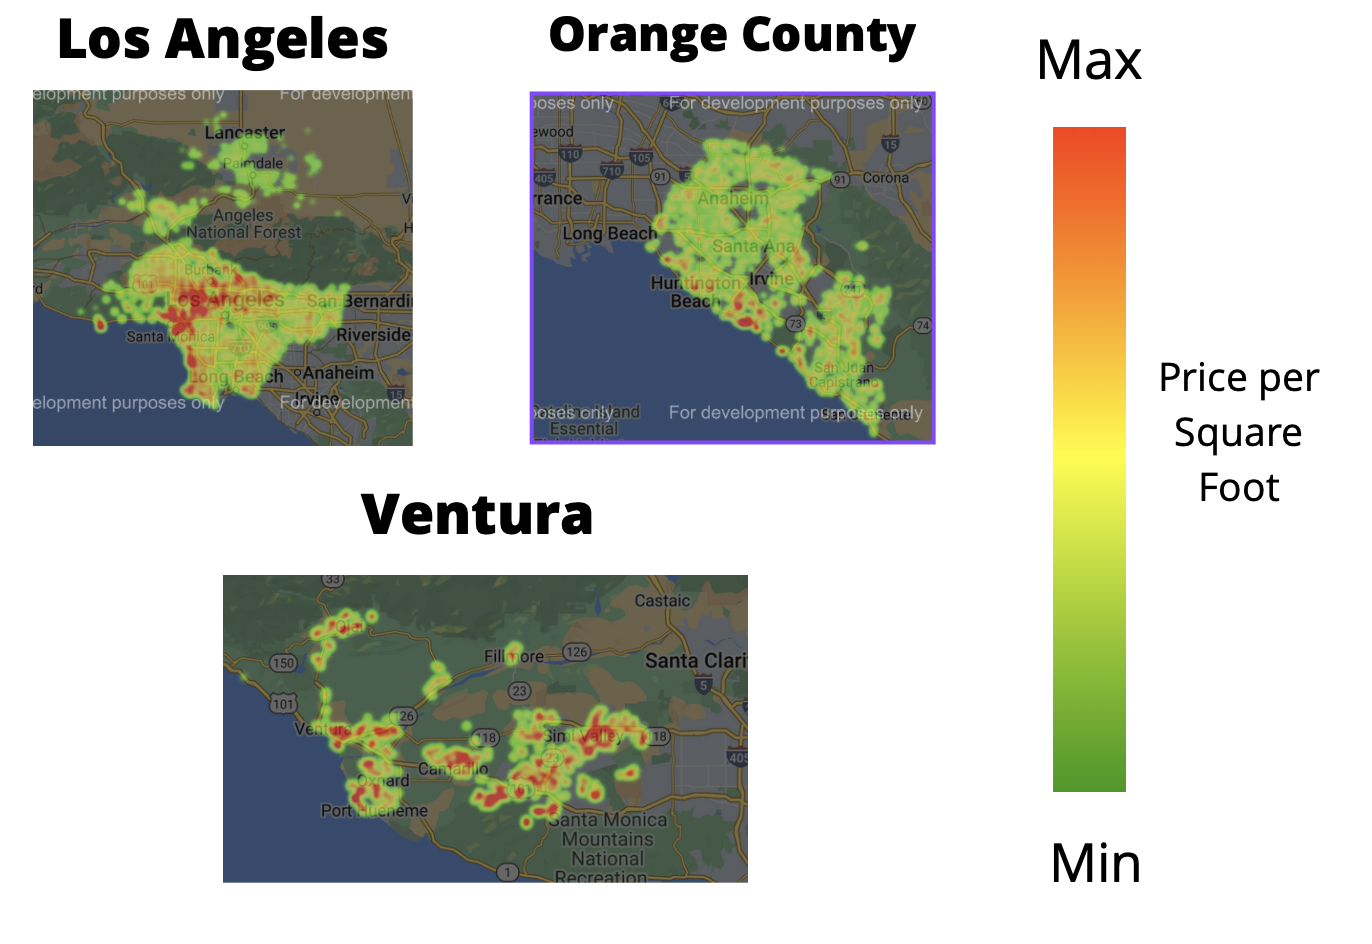

In [12]:
# display image of geographical data binned by avg price per square foot
# code in exploration notebook
Image(filename='ppsf_heatmaps.png')

This is a density map of the average price per square foot based on location. I chose this over average house price because it provided a slightly better gradient. 

What I found is that there are hotspots in certain places in each county, such as downtown santa monica and LA. Based on these visualization I wanted to add some distance-based features to my data set.

# Location, Location, Location: The Main Concept

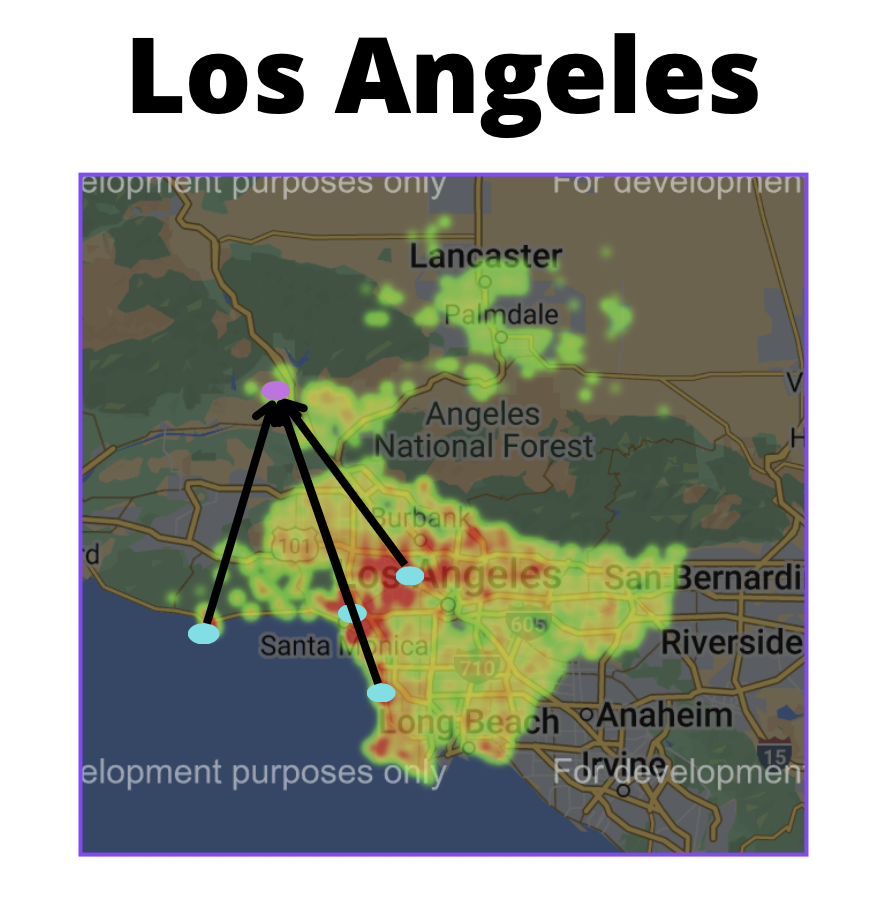

In [13]:
# Displaying picture to illustrate the idea of my distance-based features
Image(filename='la_distances.png')

## How to Create These Features:

> * Calculate distance from each designated hotspot by comparing their coordinates with the house latitude and longitude coordinates.
> * I used the library geopy to accomplish this.
> * Scale each distance and add it onto the training dataframe


In [14]:
# show the scaled data that's ready for modeling
all_counties.x_train_scaled.head()

,scaled_bedroomcnt,scaled_bathroomcnt,scaled_sqr_ft,scaled_yearbuilt,dist_from_la,dist_from_long_beach,dist_santa_monica,dist_from_malibu,dist_from_bel_air,dist_balboa_island,dist_laguna_beach,dist_seal_beach,dist_simi,dist_ventura,dist_channel_islands,dist_ojai,dist_eleanor,scaled_OC,scaled_ventura
0,0.0,0.0,-0.032258,-0.142857,0.660602,-0.303763,0.639060,0.662262,0.748439,-0.924861,-0.848921,-0.537515,0.798256,0.739388,0.787394,0.866301,0.702908,1.0,0.0
1,1.0,1.0,1.223790,0.642857,1.980096,2.281499,0.894339,-0.208093,0.901017,1.719159,1.669648,2.222510,-0.487593,-2.330260,-1.606794,-1.906196,-0.642817,0.0,1.0
2,0.0,-1.0,-0.591734,-0.392857,0.483456,-0.341801,0.547788,0.613060,0.632216,-0.760312,-0.739030,-0.568501,0.711347,0.687555,0.700411,0.793307,0.641547,1.0,0.0
3,1.0,1.0,0.876008,0.928571,0.013610,0.752180,-0.262595,-0.395752,-0.463421,0.719806,0.707754,0.795377,-0.764877,-0.672956,-0.722446,-0.719200,-0.595460,0.0,0.0
4,0.0,1.0,0.987903,0.857143,0.065350,0.041012,0.365409,0.505612,0.327095,-0.140311,-0.179081,-0.081590,0.422241,0.496224,0.311379,0.516489,0.460756,0.0,0.0


## Model and Evaluate

### Modeling Goals: 

> * Construct a model to predict property tax assessed home value for single family properties using regression techniques.

The first thing I want to do is set a baseline.

In [15]:
# set baseline
all_counties.rmse_train_mean_bl

# choose mean or median for baseline
if all_counties.rmse_train_mean_bl < all_counties.rmse_train_med_bl:
    if all_counties.rmse_val_mean_bl < all_counties.rmse_val_med_bl:
        print("We'll use mean home value to set the baseline for our model.")
else:
    print("We'll use median home value to set the baseline for our model.")
print()

# show RMSE baselines for train and validate
print(f'RMSE Baseline train:    ${round(round(all_counties.rmse_train_mean_bl,2), -3)}          Train BL normalized:{all_counties.normalized_rmse_train}')
print(f'RMSE Baseline validate: ${round(round(all_counties.rmse_val_mean_bl,2), -3)}       Validate BL normalized:{all_counties.normalized_rmse_val}')

We'll use mean home value to set the baseline for our model.

RMSE Baseline train:    $414000.0          Train BL normalized:0.89
RMSE Baseline validate: $417000.0       Validate BL normalized:0.89


My goal is to beat our baseline by getting a lower RMSE value for train and validate.

I'm going to try a few different Linear Regression Models, including OLS, Lassolars, Tweedie, and Polynomial regressions.

## Modeling Code:

In [16]:
# create linear regression models using the algorithms mentioned above
all_counties.lassolars_regression()
all_counties.OLS_regression()
all_counties.tweedie()
all_counties.poly_regression(degree=2)
all_counties.poly_regression(degree=3)

# display results
all_counties.all_models_df()

,model_name,county,rmse_train,rmse_validate,power,alpha,percent_diff,norm_rmse_train,norm_rmse_validate
0,OLS,all,310506.665528,3.113660e+05,NA,NA,-0.28,0.6674,0.6658
1,lasso_lars,all,310957.574520,3.118443e+05,NA,1,-0.29,0.6684,0.6669
2,tweedie,all,305770.788591,3.093827e+05,1,0,-1.18,0.6572,0.6616
3,polynomial,all,279484.896308,2.842974e+05,0,NA,-1.72,0.6007,0.6080
4,polynomial,all,261019.523528,1.055349e+06,0,NA,-304.32,0.5611,2.2568


## Takeaways from modeling:

* All models seemed to beat baseline
* Using polynomial regression with a degree of 3 performed best on training, but was overfit to the point of nearly doubling our RMSE.
* My best performing model was the polynomial regression with a degree of 2. It lowered our RMSE from baseline by nearly 33%.

# Test Best Model

In [17]:
# create the model object
x_test = all_counties.x_test_degree2
y_test = all_counties.y_test
lm = LinearRegression(normalize=True)

# setting shorter names for brevity
x_train = all_counties.x_train_degree2
y_train = all_counties.y_train


# fit the model to our training data. We must specify the column in self.y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(x_train, y_train.taxvaluedollarcnt)

# predict test
y_pred_test = lm.predict(x_test)

# evaluate rmse on test
rmse_test = mean_squared_error(y_test, y_pred_test)**(1/2)

# Showing RMSE Train Baseline against our test results for comparison
print(f'RMSE Train Baseline:   ${(round(round(all_counties.rmse_train_mean_bl),2)-3)}')
print(f'\nRMSE Test:    ${round(round(rmse_test,2), -3)}')

# Just the difference between baseline and test results
difference= all_counties.rmse_train_mean_bl - rmse_test
difference= round(round(difference, 2), -3)

print(f'\nI lowered baseline by about ${difference}, which improves on the current baseline by ~{round(difference/all_counties.rmse_train_mean_bl* 100)}%')

RMSE Train Baseline:   $413954

RMSE Test:    $278000.0

I lowered baseline by about $136000.0, which improves on the current baseline by ~33%


# Test Result Takeaways:



>> Test RMSE of **278,000 dollars**, improving on the last model by roughly **33%**.

# Conclusion

### Key Drivers - Square Feet, Bathroom Count, Proximity To Certain Locations

#### Locations: Los Angeles County, Orange County, and Ventura County

### Model Performance: 
> * Test RMSE of **278,000 dollars**, improving on the last model by roughly **33%**.

### Recommendations/Further Analysis:

> * Research other house properties to see what else could improve our model.
> * Try to research whether other distance-based features could be used, such as proximity to schools, to vacationing areas, etc.
> * Make linear regressions for each county, which will likely improve overall performance.